In [1]:
import pandas as pd
import numpy as np
from keras.models import Model, load_model
from keras.layers import LSTM, Dense, Dropout, Input, Conv1D, Flatten, concatenate
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Definir look_back
look_back = 6  

# Cargar el archivo y eliminar filas donde el clúster es NaN
file_path = 'data/data.csv'   # Cambia esta ruta al archivo que has subido
data = pd.read_csv(file_path)
data = data.dropna(subset=['Cluster_Label'])

# Convertir 'year' y 'month_no' a una sola columna de tipo fecha
data['date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['month_no'].astype(str))

# Seleccionar las columnas necesarias para la serie temporal
columns_to_keep = ['date', 'species', 'Cluster_Label', 'landed_w_kg',
                   'mean_temp_30m','mean_temp_10m','thetao_sfc=6',
                   'thetao_sfc=7.92956018447876','thetao_sfc=9.572997093200684','thetao_sfc=11.40499973297119',
                   'thetao_sfc=13.46714019775391','thetao_sfc=15.8100700378418','thetao_sfc=18.49555969238281',
                   'thetao_sfc=21.59881973266602','thetao_sfc=25.21141052246094','thetao_sfc=29.44473075866699']
data = data[columns_to_keep]


2024-07-19 17:47:33.228053: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-19 17:47:33.230375: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-19 17:47:33.261758: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 17:47:33.261778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 17:47:33.262636: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
data['species'].unique()

array(['MOJARRA', 'OTRAS', 'CORVINA', 'PARGO', 'SIERRA', 'TIBURON',
       'JUREL', 'GUACHINANGO', 'RONCO', 'BANDERA', 'LANGOSTA',
       'BERRUGATA', 'ROBALO', 'BAQUETA', 'LENGUADO', 'CABRILLA', 'MERO',
       'OSTION', 'JAIBA', 'LISA', 'BONITO', 'PAMPANO', 'LANGOSTINO',
       'LOBINA', 'CARACOL', 'ALMEJA', 'ESMEDREGAL', 'PIERNA', 'BARRILETE',
       'CALAMAR', 'ATUN', 'CAZON', 'ERIZO', 'SARDINA', 'RAYA Y SIMILARES',
       'ABULON', 'PULPO', 'ALGAS', 'CAMARON', 'RUBIO', 'CHARAL',
       'PEPINO DE MAR', 'MACARELA', 'CINTILLA', 'LEBRANCHA',
       'RUBIA Y VILLAJAIBA', 'FAUNA', 'PETO', 'SARGAZO', 'ANCHOVETA',
       'BESUGO'], dtype=object)

In [3]:
data['Cluster_Label'].unique()

array([7, 0, 3, 6, 5, 2, 1, 4])

In [4]:
# Función para preparar los datos
def prepare_data(group, look_back=6):
    features = ['landed_w_kg','Cluster_Label', 'mean_temp_30m','mean_temp_10m','thetao_sfc=6',
                   'thetao_sfc=7.92956018447876','thetao_sfc=9.572997093200684','thetao_sfc=11.40499973297119',
                   'thetao_sfc=13.46714019775391','thetao_sfc=15.8100700378418','thetao_sfc=18.49555969238281',
                   'thetao_sfc=21.59881973266602','thetao_sfc=25.21141052246094','thetao_sfc=29.44473075866699']
    scaler = MinMaxScaler(feature_range=(0, 1))
    group_scaled = scaler.fit_transform(group[features])
    
    X, y = [], []
    for i in range(len(group_scaled) - look_back):
        a = group_scaled[i:(i + look_back)]
        X.append(a)
        y.append(group_scaled[i + look_back, 0])  # La primera columna es 'landed_w_kg'
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
    return X, y, scaler

# Crear el modelo LSTM
def create_lstm_model(input_shape):
    lstm_input = Input(shape=input_shape)
    x = LSTM(50, return_sequences=True)(lstm_input)
    x = Dropout(0.2)(x)
    x = LSTM(25, activation='relu', return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(12, activation='linear')(x)
    lstm_output = Dense(1, activation='linear')(x)
    return Model(inputs=lstm_input, outputs=lstm_output)

# Crear el modelo DNN
def create_dnn_model(input_shape):
    dnn_input = Input(shape=(input_shape[0], input_shape[1]))
    x = Flatten()(dnn_input)
    x = Dense(10, activation='relu')(x)
    x = Dense(5, activation='relu')(x)
    dnn_output = Dense(1, activation='linear')(x)
    return Model(inputs=dnn_input, outputs=dnn_output)

# Crear el modelo CNN
def create_cnn_model(input_shape):
    cnn_input = Input(shape=input_shape)
    x = Conv1D(32, kernel_size=3, activation='relu')(cnn_input)
    x = Flatten()(x)
    cnn_output = Dense(1, activation='linear')(x)
    return Model(inputs=cnn_input, outputs=cnn_output)

# Crear el modelo Mixture of Experts (MoE)
def create_moe_model(input_shape):
    # Definir los expertos
    lstm_model = create_lstm_model(input_shape)
    dnn_model = create_dnn_model(input_shape)
    cnn_model = create_cnn_model(input_shape)
    
    # Definir el gating network
    moe_input = Input(shape=input_shape)
    x = Flatten()(moe_input)
    x = Dense(10, activation='relu')(x)
    gate_output = Dense(3, activation='softmax')(x)  # Tres expertos

    # Obtener las salidas de los expertos
    lstm_output = lstm_model(moe_input)
    dnn_output = dnn_model(moe_input)
    cnn_output = cnn_model(moe_input)
    
    # Combinar las salidas usando el gating network
    output = concatenate([lstm_output * gate_output[:, 0:1],
                          dnn_output * gate_output[:, 1:2],
                          cnn_output * gate_output[:, 2:3]], axis=1)
    output = Dense(1, activation='linear')(output)
    
    model = Model(inputs=moe_input, outputs=output)
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model


In [5]:
# Función para entrenar y guardar el modelo MoE
def train_and_save_moe_model(data, species_name, cluster_label, look_back=look_back, epochs=50, batch_size=1):
    X, y, scaler = prepare_data(data, look_back)
    model = create_moe_model((look_back, X.shape[2]))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    history = model.fit(X, y, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])
    
    # Guardar el modelo y el scaler
    model_directory = 'modelos_moe'
    os.makedirs(model_directory, exist_ok=True)
    model_path = os.path.join(model_directory, f'{species_name}_cluster_{cluster_label}_moe_model.h5')
    scaler_path = os.path.join(model_directory, f'{species_name}_cluster_{cluster_label}_moe_scaler.pkl')
    model.save(model_path)
    joblib.dump(scaler, scaler_path)
    
    # Guardar los valores de monitoreo del entrenamiento
    train_moe_directory = 'train_moe'
    os.makedirs(train_moe_directory, exist_ok=True)
    history_path = os.path.join(train_moe_directory, f'{species_name}_cluster_{cluster_label}_training_history.csv')
    pd.DataFrame(history.history).to_csv(history_path, index=False)
    
    print(f'Modelo MoE, scaler y datos de entrenamiento guardados para {species_name} en clúster {cluster_label}')
    return model, scaler

# Función para hacer predicciones con bandas de confianza usando bootstrap
def predict_with_confidence_intervals(model, scaler, data, look_back=6, n_bootstrap=100, alpha=0.01):
    features = ['landed_w_kg','Cluster_Label','mean_temp_30m','mean_temp_10m','thetao_sfc=6',
                   'thetao_sfc=7.92956018447876','thetao_sfc=9.572997093200684','thetao_sfc=11.40499973297119',
                   'thetao_sfc=13.46714019775391','thetao_sfc=15.8100700378418','thetao_sfc=18.49555969238281',
                   'thetao_sfc=21.59881973266602','thetao_sfc=25.21141052246094','thetao_sfc=29.44473075866699']
    group_scaled = scaler.transform(data[features])

    X = []
    for i in range(len(group_scaled) - look_back):
        a = group_scaled[i:(i + look_back)]
        X.append(a)
    X = np.array(X)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))
    
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, X[:, -1, 1:])))[:, 0]
    
    # Bootstrap para bandas de confianza
    bootstrap_predictions = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(range(len(X)), len(X), replace=True)
        X_sample = X[indices]
        pred_sample = model.predict(X_sample)
        pred_sample = scaler.inverse_transform(np.hstack((pred_sample, X_sample[:, -1, 1:])))[:, 0]
        bootstrap_predictions.append(pred_sample)
    
    bootstrap_predictions = np.array(bootstrap_predictions)
    lower_bound = np.percentile(bootstrap_predictions, 100 * alpha / 2, axis=0)
    upper_bound = np.percentile(bootstrap_predictions, 100 * (1 - alpha / 2), axis=0)
    
    return predictions, lower_bound, upper_bound



In [15]:
# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Definir la especie y clúster desde donde retomar el proceso y detenerlo
start_species = 'RUBIO'
start_cluster = 7.0
stop_species = 'BESUGO'
stop_cluster = 4.0

# Inicializar banderas
start_training = False
stop_training = False

for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Activar la bandera cuando se alcance la especie y clúster deseados para iniciar
        if species_name == start_species and cluster_label == start_cluster:
            start_training = True
        
        # Detener el proceso cuando se alcance la especie y clúster deseados para detener
        if species_name == stop_species and cluster_label == stop_cluster:
            stop_training = True
        
        # Continuar solo si la bandera de inicio está activada y la de detener no lo está
        if start_training and not stop_training:
            # Filtrar los datos para obtener una especie y un clúster específico
            filtered_data = data[(data['species'] == species_name) & (data['Cluster_Label'] == cluster_label)]
            
            if len(filtered_data) >= look_back:
                filtered_data = filtered_data.sort_values('date')
                try:
                    print(f'Training model for species: {species_name}, cluster: {cluster_label}')
                    model, scaler = train_and_save_moe_model(filtered_data, species_name, cluster_label, look_back)

                    # Guardar los datos para las bandas de confianza
                    test_data_2023 = filtered_data[(filtered_data['date'].dt.year == 2023) & (filtered_data['date'].dt.month >= 1)]
                    if len(test_data_2023) >= look_back:
                        predictions, lower_bound, upper_bound = predict_with_confidence_intervals(model, scaler, test_data_2023, look_back)
                        real_values = test_data_2023['landed_w_kg'].values[look_back:]
                        
                        # Crear un DataFrame para los resultados
                        results_df = pd.DataFrame({
                            'date': test_data_2023['date'].values[look_back:],
                            'real_values': real_values,
                            'predictions': predictions,
                            'lower_bound': lower_bound,
                            'upper_bound': upper_bound
                        })
                        
                        # Guardar los resultados
                        results_directory = 'resultados_moe'
                        os.makedirs(results_directory, exist_ok=True)
                        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
                        results_df.to_csv(results_path, index=False)
                        
                        # Agrupar por mes y sumar los valores
                        monthly_totals = results_df.set_index('date').resample('M').sum()
                        
                        # Calcular MSE y R2 para los totales mensuales
                        mse = mean_squared_error(monthly_totals['real_values'], monthly_totals['predictions'])
                        r2 = r2_score(monthly_totals['real_values'], monthly_totals['predictions'])
                        print(f'MSE Mensual para {species_name} en clúster {cluster_label}: {mse}, R2 Mensual: {r2}')
                        
                        # Crear figura
                        plt.figure(figsize=(10, 6))
                        plt.plot(monthly_totals.index, monthly_totals['real_values'], color='blue', label='Real')
                        plt.plot(monthly_totals.index, monthly_totals['predictions'], color='red', linestyle='--', label='Predicho')
                        plt.fill_between(monthly_totals.index, monthly_totals['lower_bound'], monthly_totals['upper_bound'], color='gray', alpha=0.2, label='Intervalo de Confianza 95%')
                        plt.title(f'Totales Mensuales de {species_name} en clúster {cluster_label} para los Últimos Seis Meses de 2023')
                        plt.xlabel('Fecha')
                        plt.ylabel('Peso Desembarcado (kg)')
                        plt.legend()
                        plot_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_plot.png')
                        plt.savefig(plot_path)
                        plt.close()
                    else:
                        print(f'No se tienen datos suficientes para {species_name} en clúster {cluster_label} en los últimos seis meses de 2023')
                except Exception as e:
                    print(f'Error entrenando el modelo para especie: {species_name}, clúster: {cluster_label}. Error: {e}')
        
        # Salir del bucle si se alcanza el punto de detener
        if stop_training:
            break
    if stop_training:
        break

Training model for species: CHARAL, cluster: 7
Epoch 1/50
204/204 [==============================] - 4s 7ms/step - loss: 0.0331 - val_loss: 0.0130
Epoch 2/50
204/204 [==============================] - 1s 4ms/step - loss: 0.0259 - val_loss: 0.0152
Epoch 3/50
204/204 [==============================] - 1s 4ms/step - loss: 0.0252 - val_loss: 0.0129
Epoch 4/50
204/204 [==============================] - 1s 4ms/step - loss: 0.0250 - val_loss: 0.0134
Epoch 5/50
204/204 [==============================] - 1s 4ms/step - loss: 0.0251 - val_loss: 0.0151
Epoch 6/50
204/204 [==============================] - 1s 4ms/step - loss: 0.0243 - val_loss: 0.0125
Epoch 7/50
204/204 [==============================] - 1s 4ms/step - loss: 0.0246 - val_loss: 0.0130
Epoch 8/50
204/204 [==============================] - 1s 4ms/step - loss: 0.0235 - val_loss: 0.0161
Epoch 9/50
204/204 [==============================] - 1s 4ms/step - loss: 0.0244 - val_loss: 0.0129
Epoch 10/50
204/204 [==============================] 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step
MSE Mensual para CHARAL en clúster 7: 3142688.255226445, R2 Mensual: 0.6401115572413221
Training model for species: CHARAL, cluster: 3


/var/tmp/ipykernel_1403898/3885310759.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Epoch 1/50
60/60 [==============================] - 4s 15ms/step - loss: 0.0340 - val_loss: 0.0393
Epoch 2/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0296 - val_loss: 0.0341
Epoch 3/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0295 - val_loss: 0.0334
Epoch 4/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0270 - val_loss: 0.0308
Epoch 5/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0271 - val_loss: 0.0307
Epoch 6/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0259 - val_loss: 0.0310
Epoch 7/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0260 - val_loss: 0.0309
Epoch 8/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0251 - val_loss: 0.0294
Epoch 9/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0211 - val_loss: 0.0306
Epoch 10/50
60/60 [==============================] - 0s 5ms/step - loss: 0.0192 - val_loss: 0.0340
Epoch 11/50
60/60 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
2/2 [==============================] - 3s 550ms/step - loss: 6.1995e-04 - val_loss: 1.2781e-04
Epoch 2/50
2/2 [==============================] - 0s 27ms/step - loss: 2.7345e-04 - val_loss: 1.0618e-05
Epoch 3/50
2/2 [==============================] - 0s 23ms/step - loss: 3.1997e-04 - val_loss: 1.5934e-05
Epoch 4/50
2/2 [==============================] - 0s 23ms/step - loss: 2.5236e-04 - val_loss: 9.1412e-05
Epoch 5/50
2/2 [==============================] - 0s 23ms/step - loss: 9.8620e-05 - val_loss: 2.4800e-04
Epoch 6/50
2/2 [==============================] - 0s 25ms/step - loss: 1.5037e-05 - val_loss: 3.6750e-04
Epoch 7/50
2/2 [==============================] - 0s 23ms/step - loss: 1.7861e-05 - val_loss: 4.1015e-04
Epoch 8/50
2/2 [==============================] - 0s 24ms/step - loss: 3.7391e-05 - val_loss: 3.7350e-04
Epoch 9/50
2/2 [==============================] - 0s 23ms/step - loss: 2.3614e-05 - val_loss: 3.0242e-04
Epoch 10/50
2/2 [==============================] - 0s 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
29/29 [==============================] - 4s 25ms/step - loss: 0.0647 - val_loss: 0.1182
Epoch 2/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0557 - val_loss: 0.1085
Epoch 3/50
29/29 [==============================] - 0s 6ms/step - loss: 0.0513 - val_loss: 0.1057
Epoch 4/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0504 - val_loss: 0.0919
Epoch 5/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0493 - val_loss: 0.0951
Epoch 6/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0489 - val_loss: 0.0939
Epoch 7/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0484 - val_loss: 0.0939
Epoch 8/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0481 - val_loss: 0.0954
Epoch 9/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0478 - val_loss: 0.0975
Epoch 10/50
29/29 [==============================] - 0s 5ms/step - loss: 0.0472 - val_loss: 0.0997
Epoch 11/50
29/29 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
44/44 [==============================] - 4s 19ms/step - loss: 0.0529 - val_loss: 0.0565
Epoch 2/50
44/44 [==============================] - 0s 5ms/step - loss: 0.0226 - val_loss: 0.0021
Epoch 3/50
44/44 [==============================] - 0s 5ms/step - loss: 0.0187 - val_loss: 0.0088
Epoch 4/50
44/44 [==============================] - 0s 5ms/step - loss: 0.0149 - val_loss: 0.0209
Epoch 5/50
44/44 [==============================] - 0s 5ms/step - loss: 0.0125 - val_loss: 0.0113
Epoch 6/50
44/44 [==============================] - 0s 5ms/step - loss: 0.0104 - val_loss: 0.0144
Epoch 7/50
44/44 [==============================] - 0s 5ms/step - loss: 0.0090 - val_loss: 0.0265
Epoch 8/50
44/44 [==============================] - 0s 5ms/step - loss: 0.0076 - val_loss: 0.0029
Epoch 9/50
44/44 [==============================] - 0s 5ms/step - loss: 0.0087 - val_loss: 0.0127
Epoch 10/50
44/44 [==============================] - 0s 5ms/step - loss: 0.0065 - val_loss: 0.0124
Epoch 11/50
44/44 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
8/8 [==============================] - 3s 82ms/step - loss: nan - val_loss: nan
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: nan - val_loss: nan
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: nan - val_loss: nan
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: nan - val_loss: nan
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: nan - val_loss: nan
Epoch 6/50
8/8 [==============================] - 0s 8ms/step - loss: nan - val_loss: nan
Epoch 7/50
8/8 [==============================] - 0s 8ms/step - loss: nan - val_loss: nan
Epoch 8/50
8/8 [==============================] - 0s 8ms/step - loss: nan - val_loss: nan
Epoch 9/50
8/8 [==============================] - 0s 8ms/step - loss: nan - val_loss: nan
Epoch 10/50
8/8 [==============================] - 0s 8ms/step - loss: nan - val_loss: nan
Epoch 10: early stopping
Modelo MoE, scaler y datos de entrenamiento guardados para PEPINO DE MAR 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
12/12 [==============================] - 4s 54ms/step - loss: 0.0143 - val_loss: 0.0144
Epoch 2/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0091 - val_loss: 0.0113
Epoch 3/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0060 - val_loss: 0.0114
Epoch 4/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0116
Epoch 5/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.0116
Epoch 6/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0051 - val_loss: 0.0115
Epoch 7/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0060 - val_loss: 0.0114
Epoch 8/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0115
Epoch 9/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0119
Epoch 10/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0114
Epoch 11/50
12/12 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
108/108 [==============================] - 4s 10ms/step - loss: 0.0659 - val_loss: 0.0364
Epoch 2/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0491 - val_loss: 0.0336
Epoch 3/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0474 - val_loss: 0.0311
Epoch 4/50
108/108 [==============================] - 0s 5ms/step - loss: 0.0451 - val_loss: 0.0353
Epoch 5/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0483 - val_loss: 0.0323
Epoch 6/50
108/108 [==============================] - 0s 5ms/step - loss: 0.0464 - val_loss: 0.0320
Epoch 7/50
108/108 [==============================] - 0s 5ms/step - loss: 0.0458 - val_loss: 0.0310
Epoch 8/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0447 - val_loss: 0.0323
Epoch 9/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0457 - val_loss: 0.0323
Epoch 10/50
108/108 [==============================] - 0s 5ms/step - loss: 0.0446 - val_loss: 0.032

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
55/55 [==============================] - 4s 15ms/step - loss: 9.7888e-04 - val_loss: 0.0718
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 9.4685e-05 - val_loss: 0.0707
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 5.6471e-05 - val_loss: 0.0710
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 4.5440e-05 - val_loss: 0.0707
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 5.7677e-05 - val_loss: 0.0699
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 9.5704e-05 - val_loss: 0.0706
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 4.0246e-05 - val_loss: 0.0706
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 4.3146e-05 - val_loss: 0.0700
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 5.1940e-05 - val_loss: 0.0706
Epoch 10/50
55/55 [==============================] - 0s 5ms/step - loss: 3.7777e-

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.2732 - val_loss: 0.4247
Epoch 2/50
1/1 [==============================] - 0s 28ms/step - loss: 0.2424 - val_loss: 0.4138
Epoch 3/50
1/1 [==============================] - 0s 26ms/step - loss: 0.2146 - val_loss: 0.4019
Epoch 4/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1896 - val_loss: 0.3904
Epoch 5/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1683 - val_loss: 0.3791
Epoch 6/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1498 - val_loss: 0.3678
Epoch 7/50
1/1 [==============================] - 0s 26ms/step - loss: 0.1272 - val_loss: 0.3559
Epoch 8/50
1/1 [==============================] - 0s 25ms/step - loss: 0.1086 - val_loss: 0.3439
Epoch 9/50
1/1 [==============================] - 0s 26ms/step - loss: 0.0920 - val_loss: 0.3322
Epoch 10/50
1/1 [==============================] - 0s 28ms/step - loss: 0.0761 - val_loss: 0.3203
Epoch 11/50
1/1 [==============

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training model for species: LEBRANCHA, cluster: 3
Error entrenando el modelo para especie: LEBRANCHA, clúster: 3. Error: tuple index out of range
Training model for species: LEBRANCHA, cluster: 1
Epoch 1/50
144/144 [==============================] - 4s 9ms/step - loss: 0.0252 - val_loss: 0.0113
Epoch 2/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0208 - val_loss: 0.0099
Epoch 3/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0199 - val_loss: 0.0098
Epoch 4/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0194 - val_loss: 0.0198
Epoch 5/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0197 - val_loss: 0.0113
Epoch 6/50
144/144 [==============================] - 1s 4ms/step - loss: 0.0189 - val_loss: 0.0136
Epoch 7/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0184 - val_loss: 0.0141
Epoch 8/50
144/144 [==============================] - 1s 5ms/step - loss: 0.0182 - val_loss: 0.0168
Epoc

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step
MSE Mensual para LEBRANCHA en clúster 1: 1930520.1427988168, R2 Mensual: 0.6373321236837171


/var/tmp/ipykernel_1403898/3885310759.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()


Training model for species: RUBIA Y VILLAJAIBA, cluster: 1
Epoch 1/50
6/6 [==============================] - 5s 115ms/step - loss: 0.1937 - val_loss: 0.0134
Epoch 2/50
6/6 [==============================] - 0s 9ms/step - loss: 0.1668 - val_loss: 0.0272
Epoch 3/50
6/6 [==============================] - 0s 9ms/step - loss: 0.1306 - val_loss: 0.0497
Epoch 4/50
6/6 [==============================] - 0s 9ms/step - loss: 0.1175 - val_loss: 0.0822
Epoch 5/50
6/6 [==============================] - 0s 9ms/step - loss: 0.1082 - val_loss: 0.1148
Epoch 6/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0999 - val_loss: 0.1286
Epoch 7/50
6/6 [==============================] - 0s 9ms/step - loss: 0.1081 - val_loss: 0.1315
Epoch 8/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0979 - val_loss: 0.1268
Epoch 9/50
6/6 [==============================] - 0s 9ms/step - loss: 0.0970 - val_loss: 0.1239
Epoch 10/50
6/6 [==============================] - 0s 9ms/step - loss: 0.09

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
35/35 [==============================] - 4s 22ms/step - loss: 0.0662 - val_loss: 0.2023
Epoch 2/50
35/35 [==============================] - 0s 6ms/step - loss: 0.0716 - val_loss: 0.1735
Epoch 3/50
35/35 [==============================] - 0s 6ms/step - loss: 0.0623 - val_loss: 0.1657
Epoch 4/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0600 - val_loss: 0.1650
Epoch 5/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0568 - val_loss: 0.1604
Epoch 6/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0576 - val_loss: 0.1562
Epoch 7/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0567 - val_loss: 0.1690
Epoch 8/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0586 - val_loss: 0.1625
Epoch 9/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0587 - val_loss: 0.1492
Epoch 10/50
35/35 [==============================] - 0s 5ms/step - loss: 0.0583 - val_loss: 0.1589
Epoch 11/50
35/35 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.6749 - val_loss: 0.0778
Epoch 2/50
1/1 [==============================] - 0s 30ms/step - loss: 0.4563 - val_loss: 0.0244
Epoch 3/50
1/1 [==============================] - 0s 27ms/step - loss: 0.3116 - val_loss: 0.0016
Epoch 4/50
1/1 [==============================] - 0s 24ms/step - loss: 0.1954 - val_loss: 0.0045
Epoch 5/50
1/1 [==============================] - 0s 23ms/step - loss: 0.1132 - val_loss: 0.0274
Epoch 6/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0477 - val_loss: 0.0652
Epoch 7/50
1/1 [==============================] - 0s 24ms/step - loss: 0.0198 - val_loss: 0.1132
Epoch 8/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0041 - val_loss: 0.1654
Epoch 9/50
1/1 [==============================] - 0s 24ms/step - loss: 4.2359e-06 - val_loss: 0.2178
Epoch 10/50
1/1 [==============================] - 0s 23ms/step - loss: 0.0028 - val_loss: 0.2667
Epoch 11/50
1/1 [==========

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.0014 - val_loss: 0.0445
Epoch 2/50
1/1 [==============================] - 0s 32ms/step - loss: 8.1807e-05 - val_loss: 0.0368
Epoch 3/50
1/1 [==============================] - 0s 32ms/step - loss: 1.1417e-04 - val_loss: 0.0331
Epoch 4/50
1/1 [==============================] - 0s 26ms/step - loss: 6.1181e-04 - val_loss: 0.0335
Epoch 5/50
1/1 [==============================] - 0s 27ms/step - loss: 5.0253e-04 - val_loss: 0.0361
Epoch 6/50
1/1 [==============================] - 0s 25ms/step - loss: 1.8216e-04 - val_loss: 0.0394
Epoch 7/50
1/1 [==============================] - 0s 31ms/step - loss: 7.2814e-06 - val_loss: 0.0425
Epoch 8/50
1/1 [==============================] - 0s 26ms/step - loss: 4.3526e-05 - val_loss: 0.0447
Epoch 9/50
1/1 [==============================] - 0s 26ms/step - loss: 9.4631e-05 - val_loss: 0.0458
Epoch 10/50
1/1 [==============================] - 0s 25ms/step - loss: 1.5934e-04 - val_loss: 0.

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training model for species: SARGAZO, cluster: 3
Epoch 1/50
2/2 [==============================] - 4s 558ms/step - loss: 0.2418 - val_loss: 0.0138
Epoch 2/50
2/2 [==============================] - 0s 27ms/step - loss: 0.2233 - val_loss: 0.0096
Epoch 3/50
2/2 [==============================] - 0s 27ms/step - loss: 0.2167 - val_loss: 0.0066
Epoch 4/50
2/2 [==============================] - 0s 27ms/step - loss: 0.2077 - val_loss: 0.0043
Epoch 5/50
2/2 [==============================] - 0s 27ms/step - loss: 0.1978 - val_loss: 0.0027
Epoch 6/50
2/2 [==============================] - 0s 27ms/step - loss: 0.1905 - val_loss: 0.0014
Epoch 7/50
2/2 [==============================] - 0s 27ms/step - loss: 0.1810 - val_loss: 7.0004e-04
Epoch 8/50
2/2 [==============================] - 0s 29ms/step - loss: 0.1716 - val_loss: 2.6900e-04
Epoch 9/50
2/2 [==============================] - 0s 26ms/step - loss: 0.1727 - val_loss: 1.6497e-05
Epoch 10/50
2/2 [==============================] - 0s 26ms/step - 

/opt/conda/envs/cedo/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 15ms/step
MSE Mensual para SARGAZO en clúster 3: 197.4953043618216, R2 Mensual: nan


/var/tmp/ipykernel_1403898/3885310759.py:58: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_totals = results_df.set_index('date').resample('M').sum()
/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [12]:
import os
import pandas as pd
from sklearn.metrics import r2_score

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Inicializar un DataFrame para almacenar los valores de R2
r2_df = pd.DataFrame(index=unique_species, columns=unique_clusters)

# Iterar sobre cada combinación de especie y clúster para cargar las predicciones y calcular el R2
for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Calcular el R2 para los totales mensuales, si hay suficientes datos
            if not monthly_totals.empty:
                r2 = r2_score(monthly_totals['real_values'], monthly_totals['predictions'])
                # Almacenar el R2 en el DataFrame
                r2_df.at[species_name, cluster_label] = r2
            else:
                #print(f'Sin datos suficientes para calcular R2 para especie: {species_name}, clúster: {cluster_label}')
                r2_df.at[species_name, cluster_label] = None
        else:
            #print(f'Archivo no encontrado para especie: {species_name}, clúster: {cluster_label}')
            r2_df.at[species_name, cluster_label] = None

# Guardar el DataFrame de R2 en un archivo CSV
r2_output_path = os.path.join(results_directory, 'r2_scores.csv')
r2_df.to_csv(r2_output_path)

print(f'Tabla de R2 guardada en: {r2_output_path}')

/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Tabla de R2 guardada en: resultados_moe/r2_scores.csv


/opt/conda/envs/cedo/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


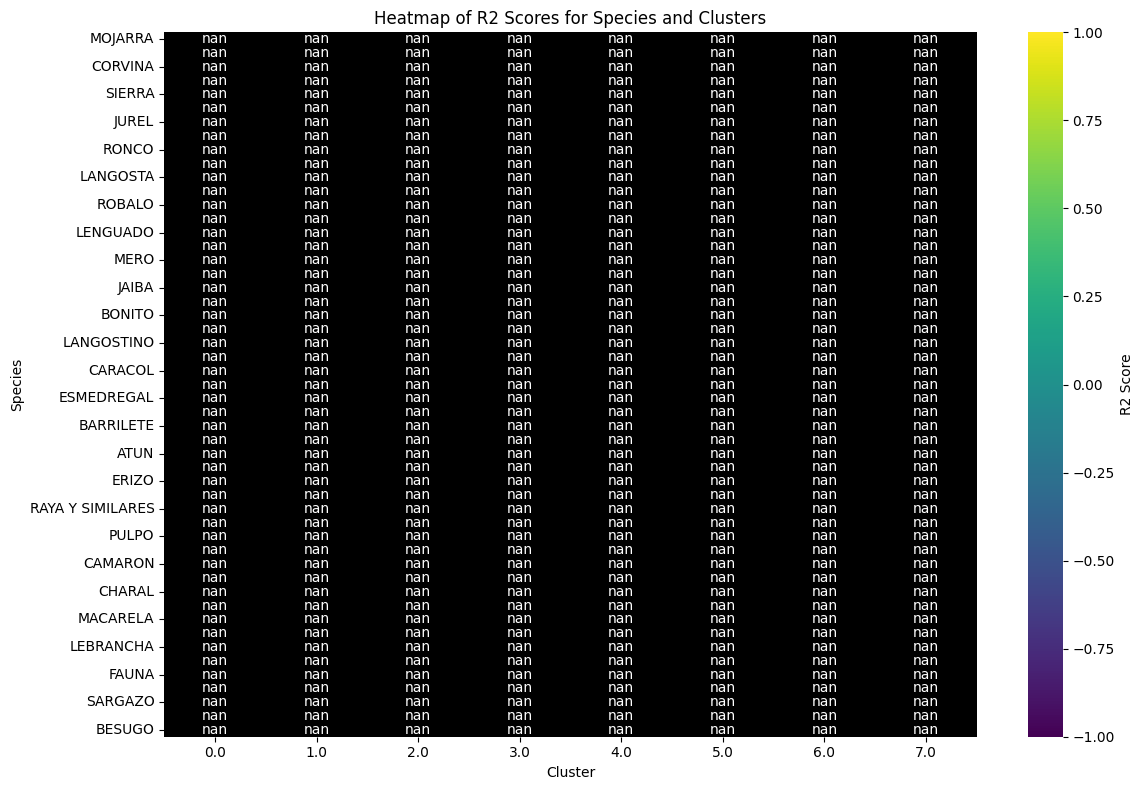

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Definir el orden deseado de las columnas
column_order = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0']

# Asegurar que las columnas estén en formato string y reindexar
r2_df.columns = r2_df.columns.astype(str)
r2_df = r2_df.reindex(columns=column_order)

# Asegurar que el índice también esté en formato string
r2_df.index = r2_df.index.astype(str)

# Reemplazar valores None o NaN con np.nan
r2_df = r2_df.apply(pd.to_numeric, errors='coerce')

# Crear una máscara para los valores fuera del rango [-1, 1]
mask = (r2_df < -1) | (r2_df > 1) | r2_df.isna()

# Crear el mapa de calor
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(r2_df, annot=True, cmap='viridis', cbar_kws={'label': 'R2 Score'}, linewidths=.5, linecolor='black', vmin=-1, vmax=1, mask=mask, annot_kws={"color": "black"})

# Pintar en negro las celdas fuera del rango [-1, 1]
for i in range(r2_df.shape[0]):
    for j in range(r2_df.shape[1]):
        if mask.iloc[i, j]:
            heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black'))
            heatmap.text(j + 0.5, i + 0.5, '{:.2f}'.format(r2_df.iloc[i, j]), ha='center', va='center', color='white')

# Añadir títulos y etiquetas
plt.title('Heatmap of R2 Scores for Species and Clusters')
plt.xlabel('Cluster')
plt.ylabel('Species')

# Mostrar el mapa de calor
plt.tight_layout()
plt.show()



In [9]:
r2_df.to_csv('tabla_resultados.csv')

/var/tmp/ipykernel_1403898/1793288187.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
/var/tmp/ipykernel_1403898/1793288187.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
/var/tmp/ipykernel_1403898/1793288187.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
/var/tmp/ipykernel_1403898/1793288187.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
/var/tmp/ipykernel_1403898/1793288187.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient i

Sin datos suficientes para calcular r para especie: LANGOSTA, clúster: 1


/var/tmp/ipykernel_1403898/1793288187.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])


Sin datos suficientes para calcular r para especie: SARGAZO, clúster: 3


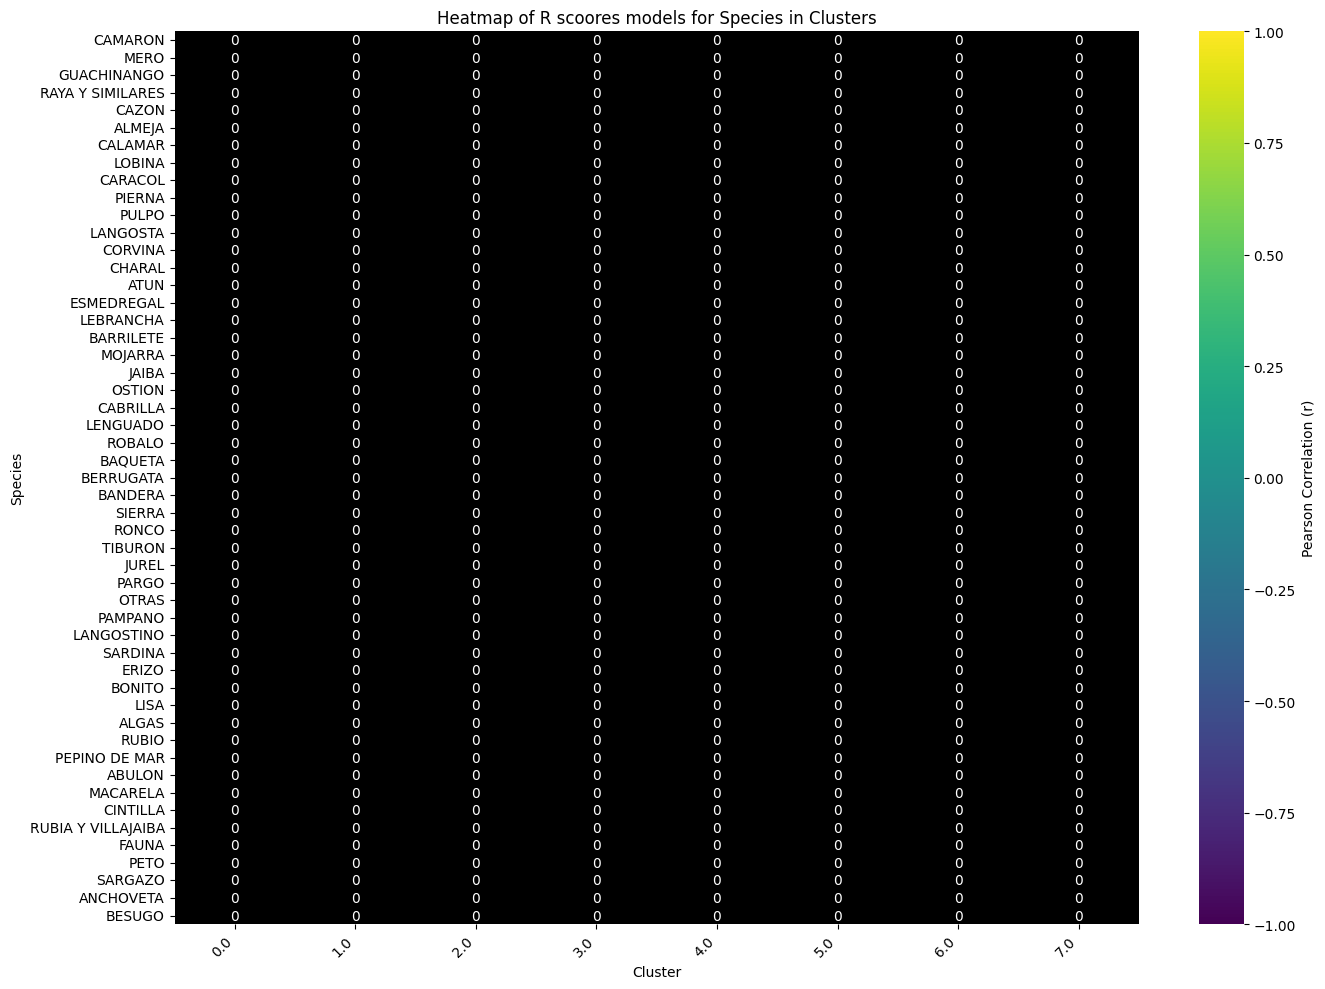

In [10]:
import os
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Directorio donde se encuentran los archivos de predicciones
results_directory = 'resultados_moe'

# Obtener listas de especies y clústeres únicos
unique_species = data['species'].unique()
unique_clusters = data['Cluster_Label'].unique()

# Inicializar un DataFrame para almacenar los valores de r
r_df = pd.DataFrame(index=unique_species, columns=unique_clusters)

# Iterar sobre cada combinación de especie y clúster para cargar las predicciones y calcular r
for species_name in unique_species:
    for cluster_label in unique_clusters:
        # Ruta del archivo de predicciones
        results_path = os.path.join(results_directory, f'{species_name}_cluster_{cluster_label}_predictions.csv')
        
        # Verificar si el archivo existe
        if os.path.exists(results_path):
            # Cargar los datos de predicciones
            results_df = pd.read_csv(results_path)
            
            # Asegurar que la columna 'date' sea de tipo datetime
            results_df['date'] = pd.to_datetime(results_df['date'])
            
            # Agrupar los resultados por mes y sumar los valores
            monthly_totals = results_df.set_index('date').resample('ME').sum()
            
            # Excluir filas con valores NaN
            monthly_totals = monthly_totals.dropna(subset=['real_values', 'predictions'])
            
            # Verificar si hay suficientes datos para calcular el coeficiente de correlación de Pearson (r)
            if len(monthly_totals) >= 2:
                r, _ = pearsonr(monthly_totals['real_values'], monthly_totals['predictions'])
                # Almacenar el valor de r en el DataFrame
                r_df.at[species_name, cluster_label] = r
            else:
                print(f'Sin datos suficientes para calcular r para especie: {species_name}, clúster: {cluster_label}')
                r_df.at[species_name, cluster_label] = None
        else:
            #print(f'Archivo no encontrado para especie: {species_name}, clúster: {cluster_label}')
            r_df.at[species_name, cluster_label] = None

# Reemplazar valores None o NaN con np.nan
r_df = r_df.apply(pd.to_numeric, errors='coerce')

# Contar los valores no nulos por fila y ordenar las especies
r_df['non_null_count'] = r_df.notnull().sum(axis=1)
r_df = r_df.sort_values(by='non_null_count', ascending=False).drop(columns=['non_null_count'])

# Definir el orden deseado de las columnas
column_order = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0']

# Reindexar el DataFrame según el orden de las columnas
r_df.columns = r_df.columns.astype(str)
r_df = r_df.reindex(columns=column_order)
r_df.index = r_df.index.astype(str)

# Crear una máscara para los valores fuera del rango [-1, 1]
mask = (r_df < -1) | (r_df > 1) | r_df.isna()

# Crear el mapa de calor
plt.figure(figsize=(14, 10))  # Aumentar el tamaño de la figura
heatmap = sns.heatmap(r_df, annot=True, cmap='viridis', cbar_kws={'label': 'Pearson Correlation (r)'}, linewidths=.5, linecolor='black', vmin=-1, vmax=1, mask=mask, annot_kws={"color": "black"}, fmt=".4g")

# Pintar en negro las celdas fuera del rango [-1, 1]
for i in range(r_df.shape[0]):
    for j in range(r_df.shape[1]):
        if mask.iloc[i, j]:
            heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black'))
            heatmap.text(j + 0.5, i + 0.5, '{:.4g}'.format(r_df.iloc[i, j] if not np.isnan(r_df.iloc[i, j]) else 0), ha='center', va='center', color='white')

# Ajustar los ticks de los ejes para mayor claridad
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas de las columnas
plt.yticks(rotation=0)  # Asegurar que las etiquetas de los renglones estén rectas

# Añadir títulos y etiquetas
plt.title('Heatmap of R scoores models for Species in Clusters')
plt.xlabel('Cluster')
plt.ylabel('Species')

# Mostrar el mapa de calor
plt.tight_layout()
plt.show()
